# Environment

In [25]:
import pandas as pd
import yaml
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load config
CONFIG_PATH = "/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_MeCP2_CUTandTAG/iterative_alternative/code7_cpg_enrichment/config.yaml"

# Specify which configuration to use (1-based index)
# Change this to select different configurations
CONFIG_NUMBER = 4

with open(CONFIG_PATH, 'r') as f:
    # Load all documents from the YAML file
    configs = list(yaml.safe_load_all(f))

# Select the specific configuration (subtract 1 because list is 0-based)
config = configs[CONFIG_NUMBER - 1]

# Get values from the selected config
BASE_DIR = config['base_dir']
RUN_NAME = config['run_name']
CELL_TYPE = config['cell_type']
ALIGNMENT_TYPE = config['alignment_type']
PEAKS_TYPE = config['peaks_type']

ENRICHMENT_FILE = f"{BASE_DIR}/results/{ALIGNMENT_TYPE}/cpg_enrichment/{CELL_TYPE}/{PEAKS_TYPE}/{RUN_NAME}/cpg_enrichment_parallel.csv"
print(ENRICHMENT_FILE)

# Set pandas display options to show all columns without wrapping
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Don't wrap wide DataFrames
pd.set_option('display.max_colwidth', None) # Don't truncate column contents

/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_MeCP2_CUTandTAG/iterative_alternative/results/no_dedup/cpg_enrichment/NSC/broad/cpg_enrichment_2_rep_in_peaks/cpg_enrichment_parallel.csv


# Load Data

In [26]:
# Load the CpG enrichment results
cpg_enrichment_df = pd.read_csv(ENRICHMENT_FILE)

In [19]:
# Display first few rows and basic info
print("DataFrame shape:", cpg_enrichment_df.shape)
print("\nFirst few rows:")
display(cpg_enrichment_df.head())
print("\nColumn names:")
print(cpg_enrichment_df.columns.tolist())

DataFrame shape: (12829, 24)

First few rows:


,chr,start,end,exo_signal,endo_signal,enrichment,pvalue,binding_type,binding_type_by_peaks,significant,exo_replicates_with_signal,endo_replicates_with_signal,exo_replicate_signals,endo_replicate_signals,region_length,cpg_length,cpg_score,cpg_name,exo_replicates_with_peaks,endo_replicates_with_peaks,exo_peak_scores_by_rep,endo_peak_scores_by_rep,region_start,region_end
0,chr1,3671654,3672156,15.331182,5.965003,2.570188,0.1,both,exo_only,False,3,3,"14.398215172280159,21.305724717144454,10.289605426735111","10.282046731029238,6.968618375914438,0.6443446448871067",1792,502,CpG:,613,2,0,5.54931;6.06037,NaN,3670396,3672188
1,chr1,4491701,4493673,8.716315,10.776053,0.808860,1.0,both,exo_only,False,2,2,"12.917271586025462,0.0,13.231673493104822","0.0,27.234050478654748,5.094107347376206",1360,1972,CpG:,619,2,1,6.0982;5.8282,4.1282,4492093,4493453
2,chr1,4571641,4572075,25.026296,0.076022,329.197490,0.5,exo_only,exo_only,False,3,1,"30.021045078151403,13.556918122386204,31.500924768035347","0.22806640496387434,0.0,0.0",786,434,CpG:,619,3,0,4.35039;6.82732;3.40697,NaN,4571438,4572224
3,chr1,4785376,4785814,25.444773,24.523792,1.037555,1.0,both,both,False,3,3,"43.13485337533006,25.311575742503305,7.887889002847865","36.00965611506565,11.335664996729886,26.22605557141936",2211,438,CpG:,621,3,3,2.96862;6.6373;7.27926,12.2007;6.57158;5.01142,4784061,4786272
4,chr1,4807559,4808103,18.253522,5.436937,3.357317,0.1,both,exo_only,False,3,3,"13.67224773939918,13.221223759008389,27.86709427862775","8.57153564399364,1.2887255350748699,6.450549572998402",3264,544,CpG:,621,3,1,4.55161;7.91139;6.13029,3.25084,4806809,4810073



Column names:
['chr', 'start', 'end', 'exo_signal', 'endo_signal', 'enrichment', 'pvalue', 'binding_type', 'binding_type_by_peaks', 'significant', 'exo_replicates_with_signal', 'endo_replicates_with_signal', 'exo_replicate_signals', 'endo_replicate_signals', 'region_length', 'cpg_length', 'cpg_score', 'cpg_name', 'exo_replicates_with_peaks', 'endo_replicates_with_peaks', 'exo_peak_scores_by_rep', 'endo_peak_scores_by_rep', 'region_start', 'region_end']


**Columns explanation:**

1. Signal vs Peaks columns:

- `endo_replicates_with_signal`: Counts how many replicates have a non-zero signal value when measuring the bigWig signal in the region. This is calculated using `pyBigWig.stats()` to get the mean signal value in the region.
- `endo_replicates_with_peaks`: Counts how many replicates have an overlapping peak in the broadPeak files.

It's possible to have `endo_replicates_with_peaks=0` but `endo_replicates_with_signal=2` because:
- Peaks represent regions that passed the peak caller's statistical threshold for significance
- Signal values represent the raw enrichment data before any statistical filtering
- So you can have detectable signal in a region that wasn't strong/consistent enough to be called as a peak

2. Scores vs Signals:

- `endo_peak_scores_by_rep`: Contains the `signalValue` scores from the broadPeak files for each replicate that has a peak overlapping the region. These scores are peak caller-specific enrichment metrics.
- `endo_replicate_signals`: Contains the actual signal values extracted from the bigWig files for each replicate in that region. These are the raw signal values.

`endo_peak_scores_by_rep` is NaN when there are no peaks overlapping the region in any replicate (`endo_replicates_with_peaks=0`). This makes sense because if there are no peaks, there are no peak scores to report.

So in summary:
- Signal columns reflect raw data from bigWig files
- Peak columns reflect statistically significant regions called by the peak caller
- You can have signal without peaks (but not vice versa)
- Peak scores are only available when peaks are present

**Handling multiple replicates:**

1. For Signals (from bigWig files):
- Each replicate's signal is obtained independently using `get_signal_from_bigwig()`
- The signals are stored as individual values in `endo_replicate_signals` as a comma-separated string
- The final `endo_signal` used for enrichment calculations is the mean across all replicates

2. For Peak Scores:
- Peak scores are stored in `endo_peak_scores_by_rep` using a specific format:
  - Scores from different peaks within the same replicate are comma-separated
  - Different replicates are semicolon-separated
  - If a replicate has no peaks, it's simply not included in the string
- There's no averaging of peak scores

For example:
- If replicate 1 has two peaks with scores 5.0 and 6.0, and replicate 2 has one peak with score 4.0, while replicate 3 has no peaks:
  - `endo_peak_scores_by_rep` would be: `"5.0, 6.0; 4.0"`
  - `endo_replicates_with_peaks` would be `2`
  - If all replicates had signals of `2.0`, `3.0`, and `1.0`:
    - `endo_replicate_signals` would be `"2.0, 3.0, 1.0"`
    - `endo_signal` would be `2.0` (the mean)
    - `endo_replicates_with_signal` would be `3`

In [27]:
# Sort the DataFrame by enrichment value in descending order
cpg_enrichment_df_sorted = cpg_enrichment_df.sort_values(by='enrichment', ascending=False)

# Split data based on binding type

## By signal value

Non zero signal in minumum 2 replicates

In [28]:
# Split data based on binding type
exo_only_df = cpg_enrichment_df_sorted[cpg_enrichment_df_sorted['binding_type'] == 'exo_only']
endo_only_df = cpg_enrichment_df_sorted[cpg_enrichment_df_sorted['binding_type'] == 'endo_only'] 
both_df = cpg_enrichment_df_sorted[cpg_enrichment_df_sorted['binding_type'] == 'both']

# Print sizes of each group
print(f"Number of CpG islands bound by exo only: {len(exo_only_df)}")
print(f"Number of CpG islands bound by endo only: {len(endo_only_df)}")
print(f"Number of CpG islands bound by both: {len(both_df)}")


Number of CpG islands bound by exo only: 126
Number of CpG islands bound by endo only: 33
Number of CpG islands bound by both: 12670


## By peaks number

Minimum 2 replicates with peaks

In [24]:
# Split data based on binding type
exo_only_df_by_peaks = cpg_enrichment_df_sorted[cpg_enrichment_df_sorted['binding_type_by_peaks'] == 'exo_only']
endo_only_df_by_peaks = cpg_enrichment_df_sorted[cpg_enrichment_df_sorted['binding_type_by_peaks'] == 'endo_only'] 
both_df_by_peaks = cpg_enrichment_df_sorted[cpg_enrichment_df_sorted['binding_type_by_peaks'] == 'both']

# Print sizes of each group
print(f"Number of CpG islands bound by exo only: {len(exo_only_df_by_peaks)}")
print(f"Number of CpG islands bound by endo only: {len(endo_only_df_by_peaks)}")
print(f"Number of CpG islands bound by both: {len(both_df_by_peaks)}")


Number of CpG islands bound by exo only: 2192
Number of CpG islands bound by endo only: 869
Number of CpG islands bound by both: 9768


# Data analysis

## Both: enrichment distribution (selected by the signal value)

In [34]:
# Print summary statistics of enrichment values
print("Summary statistics of enrichment values:")
print(both_df['enrichment'].describe())

Summary statistics of enrichment values:
count    12670.000000
mean         1.760810
std          2.648713
min          0.011030
25%          1.005493
50%          1.376620
75%          1.901880
max        145.519579
Name: enrichment, dtype: float64


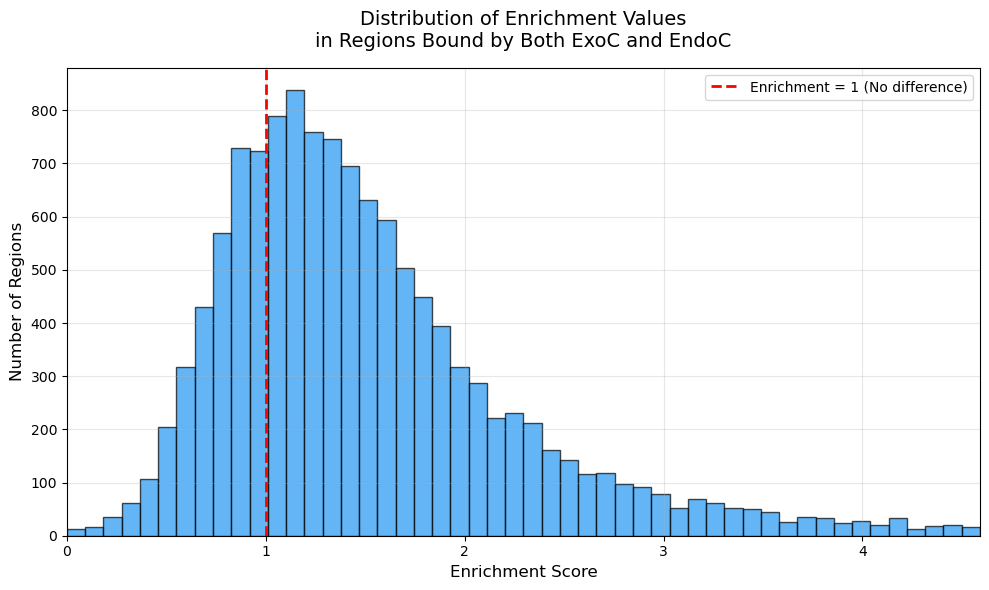

In [31]:
# Create histogram of enrichment values for regions bound by both
plt.figure(figsize=(10, 6))

# Plot histogram with better binning and transparency
# Calculate reasonable range based on data distribution
q1, q3 = both_df['enrichment'].quantile([0.25, 0.75])
factor = 3
iqr = q3 - q1
range_min = max(0, q1 - factor * iqr)  # Don't go below 0 for enrichment
range_max = q3 + factor * iqr

# Plot histogram and get the axis object
n, bins, patches = plt.hist(both_df['enrichment'], bins=50, edgecolor='black', alpha=0.7,
                          color='#2196F3', density=False, range=(range_min, range_max))

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Improve axis labels and title
plt.xlabel('Enrichment Score', fontsize=12)
plt.ylabel('Number of Regions', fontsize=12)
plt.title('Distribution of Enrichment Values\nin Regions Bound by Both ExoC and EndoC',
          fontsize=14, pad=15)

# Add vertical line at enrichment = 1
plt.axvline(x=1, color='red', linestyle='--', linewidth=2,
            label='Enrichment = 1 (No difference)')

# Set x-axis limits based on the actual data range
plt.xlim(range_min, range_max)

# Add legend with better positioning
plt.legend(loc='upper right')

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()


## Enrichment outliers

In [37]:
# Find outliers (values > range_max)
outliers_df = both_df[both_df['enrichment'] > range_max].copy()
print(f"\nNumber of outliers (enrichment > {range_max}):", len(outliers_df))


Number of outliers (enrichment > 4.59104057176528): 388


In [38]:
outliers_df.head()

,chr,start,end,exo_signal,endo_signal,enrichment,pvalue,binding_type,binding_type_by_peaks,significant,exo_replicates_with_signal,endo_replicates_with_signal,exo_replicate_signals,endo_replicate_signals,region_length,cpg_length,cpg_score,cpg_name,exo_replicates_with_peaks,endo_replicates_with_peaks,exo_peak_scores_by_rep,endo_peak_scores_by_rep,region_start,region_end
8041,chr4,65124446,65124914,11.989099,0.082388,145.519579,0.333333,both,exo_only,False,2,2,"27.14894235092685,0.0,8.818354424292076","0.1112775205875189,0.0,0.1358871353598072",1726,468,CpG:,1081,2,0,5.03423;4.60311,NaN,65124551,65126277
11895,chr9,24695948,24696360,26.633257,0.261054,102.021948,0.200000,both,exo_only,False,3,2,"1.9792640686035157,48.39018314068134,29.53032275860126","0.6303655184232272,0.1527970424065223,0.0",325,412,CpG:,773,2,0,3.76836;5.87655,NaN,24695936,24696261
10196,chr7,16475558,16476830,25.024436,0.281143,89.009740,0.200000,both,exo_only,False,3,2,"22.89691719561634,22.30488237016239,29.871508025658407","0.16219828857719246,0.0,0.6812297194361251",821,1272,CpG:,710,2,0,4.48563;4.10961,NaN,16476257,16477078
9831,chr6,88446045,88446698,25.803111,0.390391,66.095515,0.200000,both,exo_only,False,3,2,"14.559296809052128,57.02419057397183,5.825846814733791","0.35847557915581596,0.8126981973856662,0.0",1143,653,CpG:,1259,3,0,2.38625;5.40709;9.97263,NaN,88446334,88447477
9940,chr6,116460726,116461210,10.831672,0.181942,59.533679,0.200000,both,exo_only,False,3,2,"9.075827714417795,13.937311828198727,9.481875796303106","0.0,0.24418975367690576,0.30163599779613337",1914,484,CpG:,1473,2,0,3.13125;5.79508,NaN,116460024,116461938


In [56]:
# Print first 10 and last 10 outliers sorted by enrichment value
print("\nFirst 10 outliers:")
for _, row in outliers_df[:10].iterrows():
    print(f"{row['chr']}:{row['start']:,}-{row['end']:,}".ljust(50) + f"enrichment: {row['enrichment']}")

print("\nLast 10 outliers:")
for _, row in outliers_df[-10:].iterrows():
    print(f"{row['chr']}:{row['start']:,}-{row['end']:,}".ljust(50) + f"enrichment: {row['enrichment']}")


First 10 outliers:
chr4:65,124,446-65,124,914                        enrichment: 145.5195793968374
chr9:24,695,948-24,696,360                        enrichment: 102.02194788682628
chr7:16,475,558-16,476,830                        enrichment: 89.00973986893229
chr6:88,446,045-88,446,698                        enrichment: 66.0955152414275
chr6:116,460,726-116,461,210                      enrichment: 59.53367947778973
chr6:6,862,725-6,862,995                          enrichment: 50.15800281178045
chrX:95,711,569-95,712,121                        enrichment: 46.21356563847447
chr9:40,876,202-40,876,450                        enrichment: 44.55580705205183
chr12:73,545,288-73,546,556                       enrichment: 42.125683387103216
chr2:13,793,075-13,793,793                        enrichment: 41.270413761028514

Last 10 outliers:
chr4:114,406,300-114,406,926                      enrichment: 4.643519889768628
chr18:62,922,194-62,922,886                       enrichment: 4.643161579530034

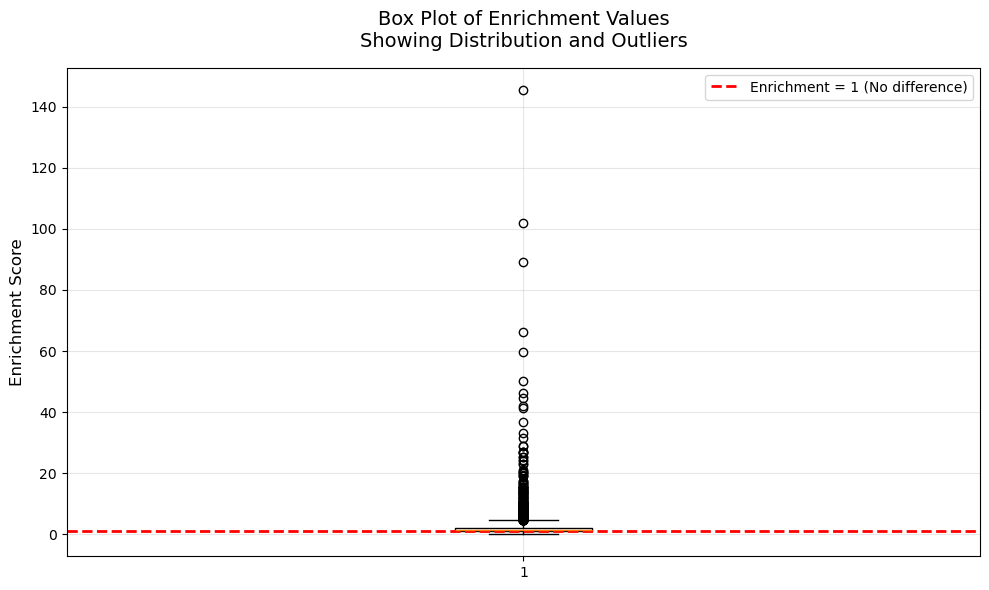

In [42]:
# Create box plot to visualize distribution and outliers
plt.figure(figsize=(10, 6))
# The whis parameter controls the whisker length in the boxplot
# whis=factor means whiskers extend to points within factor * IQR of Q1/Q3
# Points beyond the whiskers are considered outliers and plotted individually
plt.boxplot(both_df['enrichment'], whis=factor)
plt.ylabel('Enrichment Score', fontsize=12)
plt.title('Box Plot of Enrichment Values\nShowing Distribution and Outliers',
          fontsize=14, pad=15)
plt.grid(True, alpha=0.3)

# Add horizontal line at enrichment = 1
plt.axhline(y=1, color='red', linestyle='--', linewidth=2,
            label='Enrichment = 1 (No difference)')

plt.legend()
plt.tight_layout()
plt.show()

In [44]:
outliers_df["endo_replicates_with_peaks"].value_counts()

endo_zero_peaks  = outliers_df[outliers_df["endo_replicates_with_peaks"] == 0]
endo_one_peaks   = outliers_df[outliers_df["endo_replicates_with_peaks"] == 1]
endo_two_peaks   = outliers_df[outliers_df["endo_replicates_with_peaks"] == 2]
endo_three_peaks = outliers_df[outliers_df["endo_replicates_with_peaks"] == 3]

endo_replicates_with_peaks
0    189
1    126
2     54
3     19
Name: count, dtype: int64

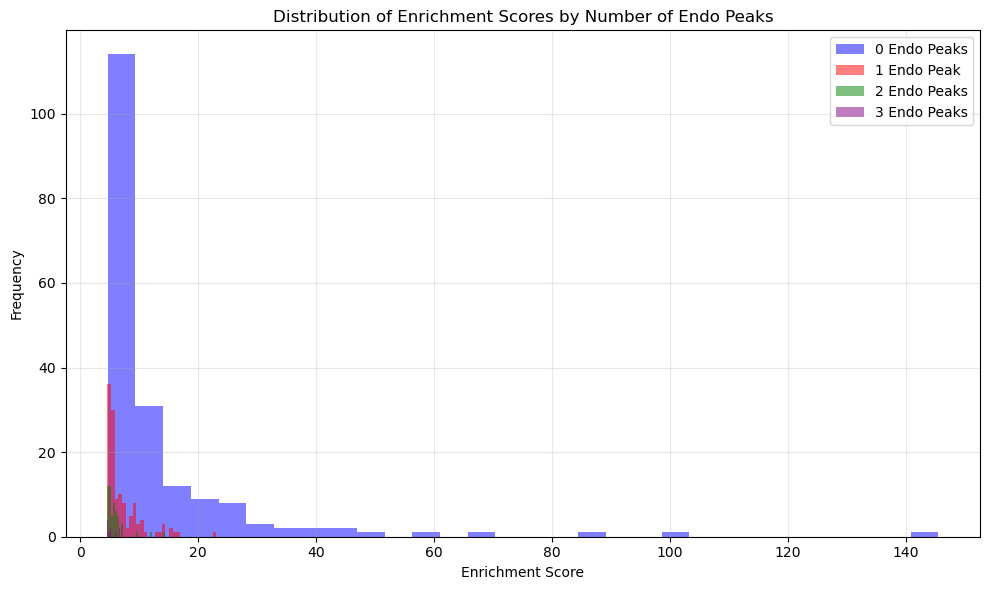

In [48]:
plt.figure(figsize=(10, 6))

# Plot overlapping histograms with transparency
plt.hist(endo_zero_peaks['enrichment'], bins=30, alpha=0.5, label='0 Endo Peaks', color='blue')
plt.hist(endo_one_peaks['enrichment'], bins=30, alpha=0.5, label='1 Endo Peak', color='red')
plt.hist(endo_two_peaks['enrichment'], bins=30, alpha=0.5, label='2 Endo Peaks', color='green')
plt.hist(endo_three_peaks['enrichment'], bins=30, alpha=0.5, label='3 Endo Peaks', color='purple')

plt.xlabel('Enrichment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Enrichment Scores by Number of Endo Peaks')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [51]:
print("top enrichment values for endo_two_peaks")
endo_two_peaks["enrichment"][:10]

top enrichment values for endo_two_peaks


6515     14.340946
5782     11.914510
7494      9.535981
1374      7.117708
3012      7.037845
10736     6.967659
10743     6.499840
7604      6.492541
191       6.265185
11475     6.244491
Name: enrichment, dtype: float64

In [60]:
# Print first 10 and last 10 endo_two_peaks sorted by enrichment value
print("\nFirst 10 endo_two_peaks:")
for _, row in endo_two_peaks[:10].iterrows():
    print(f"{row['chr']}:{row['start']:,}-{row['end']:,}".ljust(50) + 
          f"enrichment: {row['enrichment']:<10.2f}" +
          f"region_length: {row['region_length']:<10}" + 
          f"cpg_length: {row['cpg_length']}")

print("\nLast 10 endo_two_peaks:")
for _, row in endo_two_peaks[-10:].iterrows():
    print(f"{row['chr']}:{row['start']:,}-{row['end']:,}".ljust(50) + 
          f"enrichment: {row['enrichment']:<10.2f}" +
          f"region_length: {row['region_length']:<10}" + 
          f"cpg_length: {row['cpg_length']}")


First 10 endo_two_peaks:
chr2:50,066,300-50,067,004                        enrichment: 14.34     region_length: 3272      cpg_length: 704
chr19:4,476,634-4,477,151                         enrichment: 11.91     region_length: 3175      cpg_length: 517
chr3:89,430,159-89,430,653                        enrichment: 9.54      region_length: 1383      cpg_length: 494
chr11:3,452,179-3,452,683                         enrichment: 7.12      region_length: 2431      cpg_length: 504
chr13:23,585,617-23,585,879                       enrichment: 7.04      region_length: 3160      cpg_length: 262
chr7:99,828,122-99,828,450                        enrichment: 6.97      region_length: 1136      cpg_length: 328
chr7:100,227,219-100,227,913                      enrichment: 6.50      region_length: 1900      cpg_length: 694
chr3:103,279,249-103,280,584                      enrichment: 6.49      region_length: 3267      cpg_length: 1335
chr1:61,638,736-61,639,406                        enrichment: 6.27   

chr2:50,066,300-50,067,004

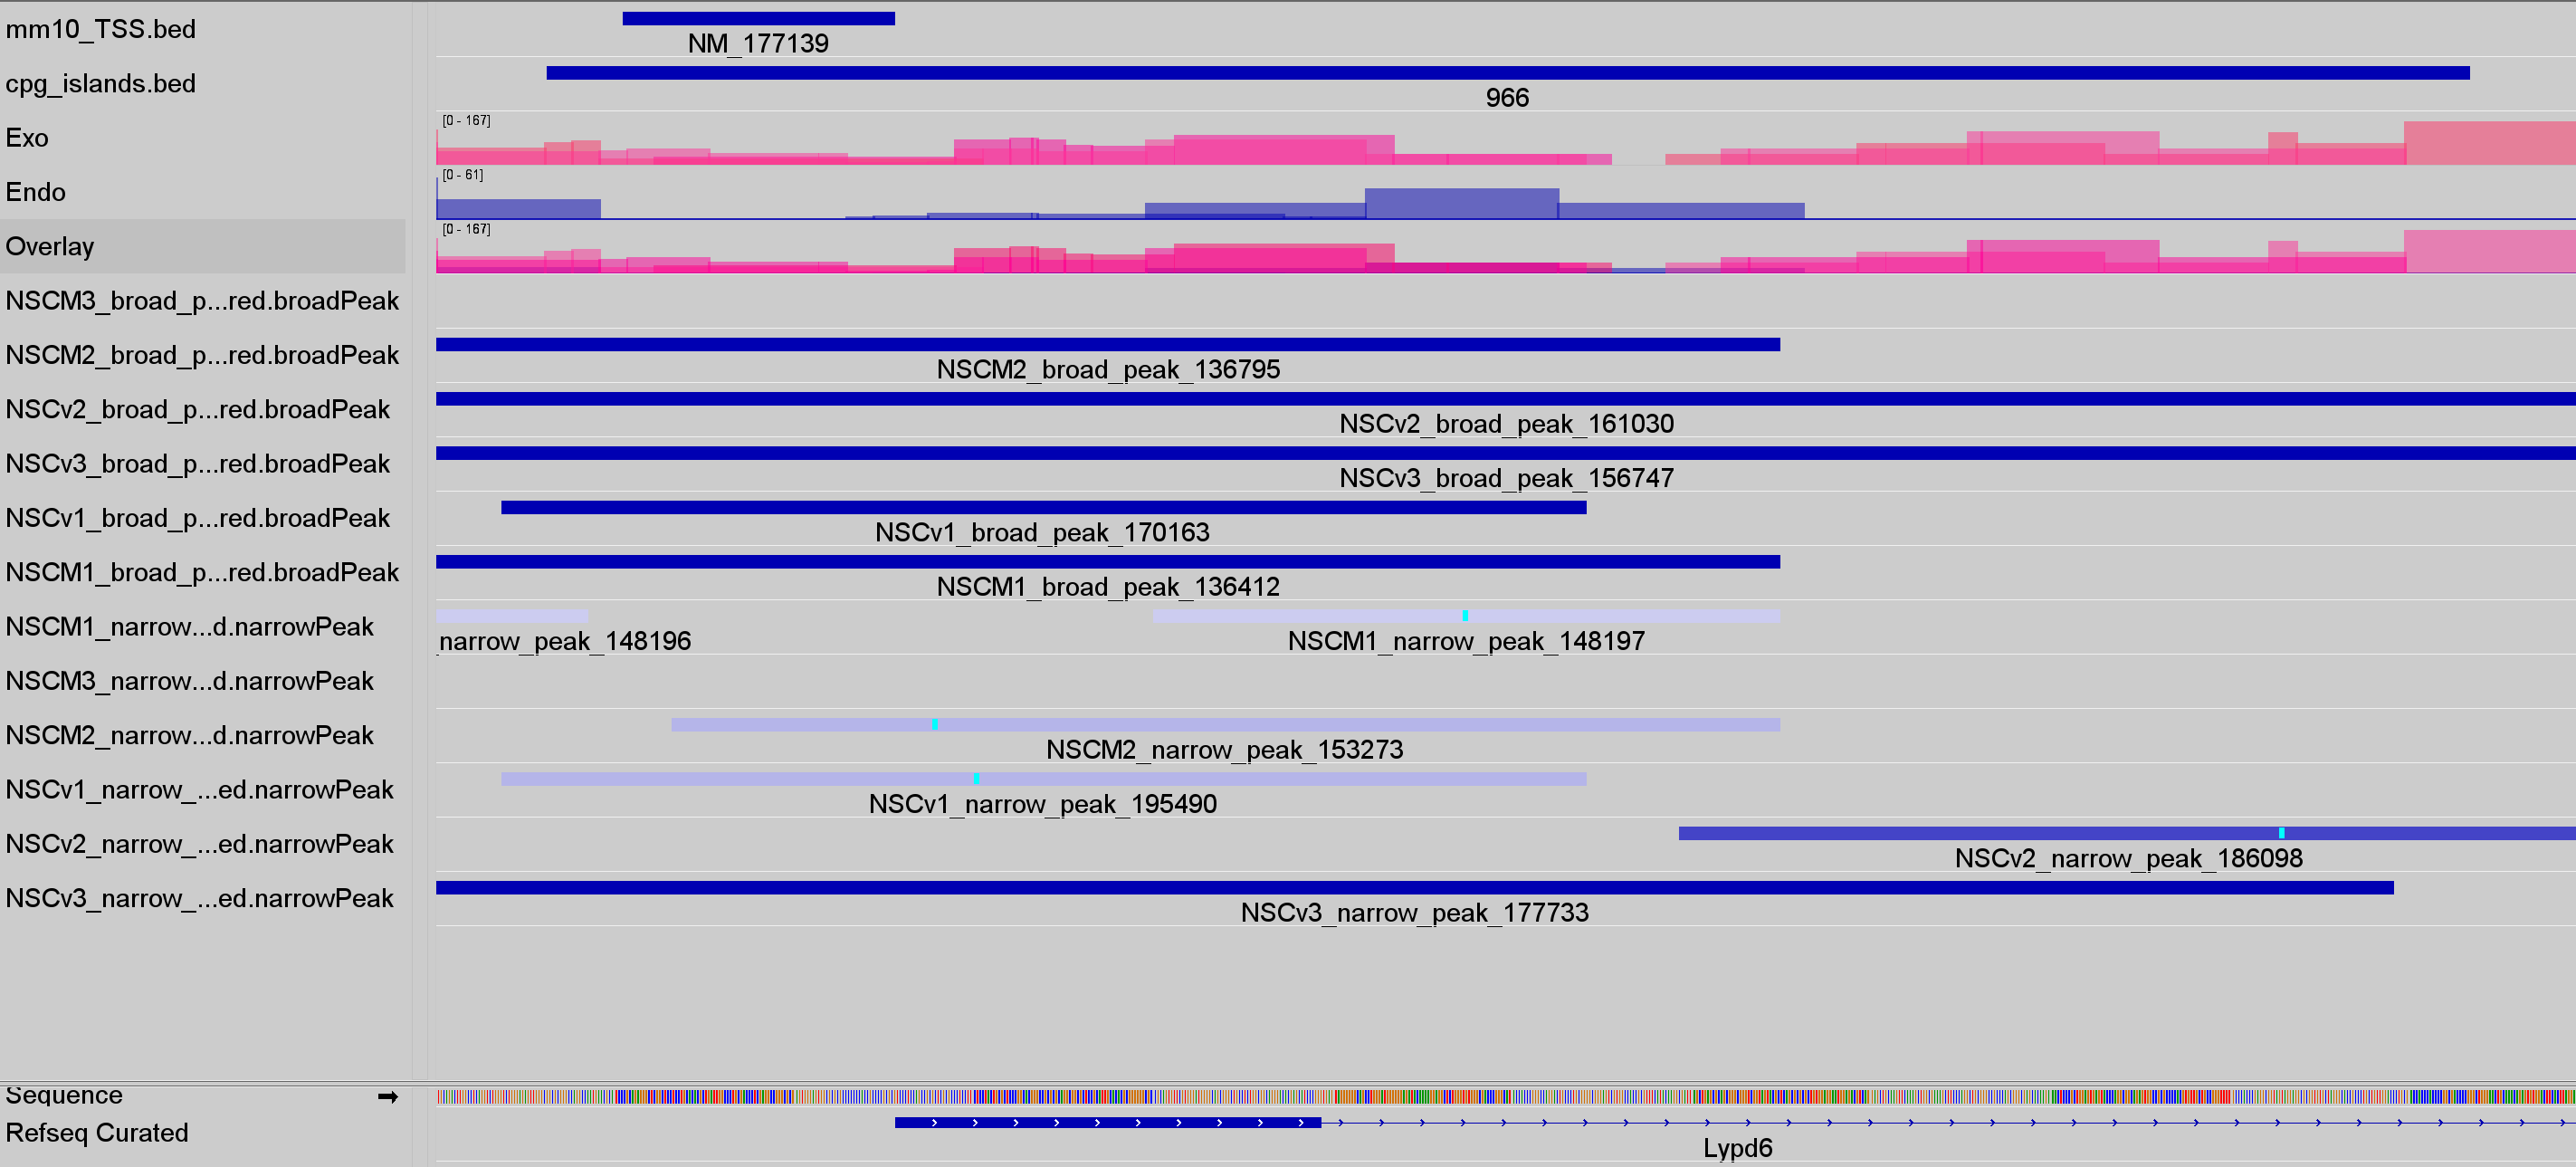

chr9:20,492,516-20,492,906

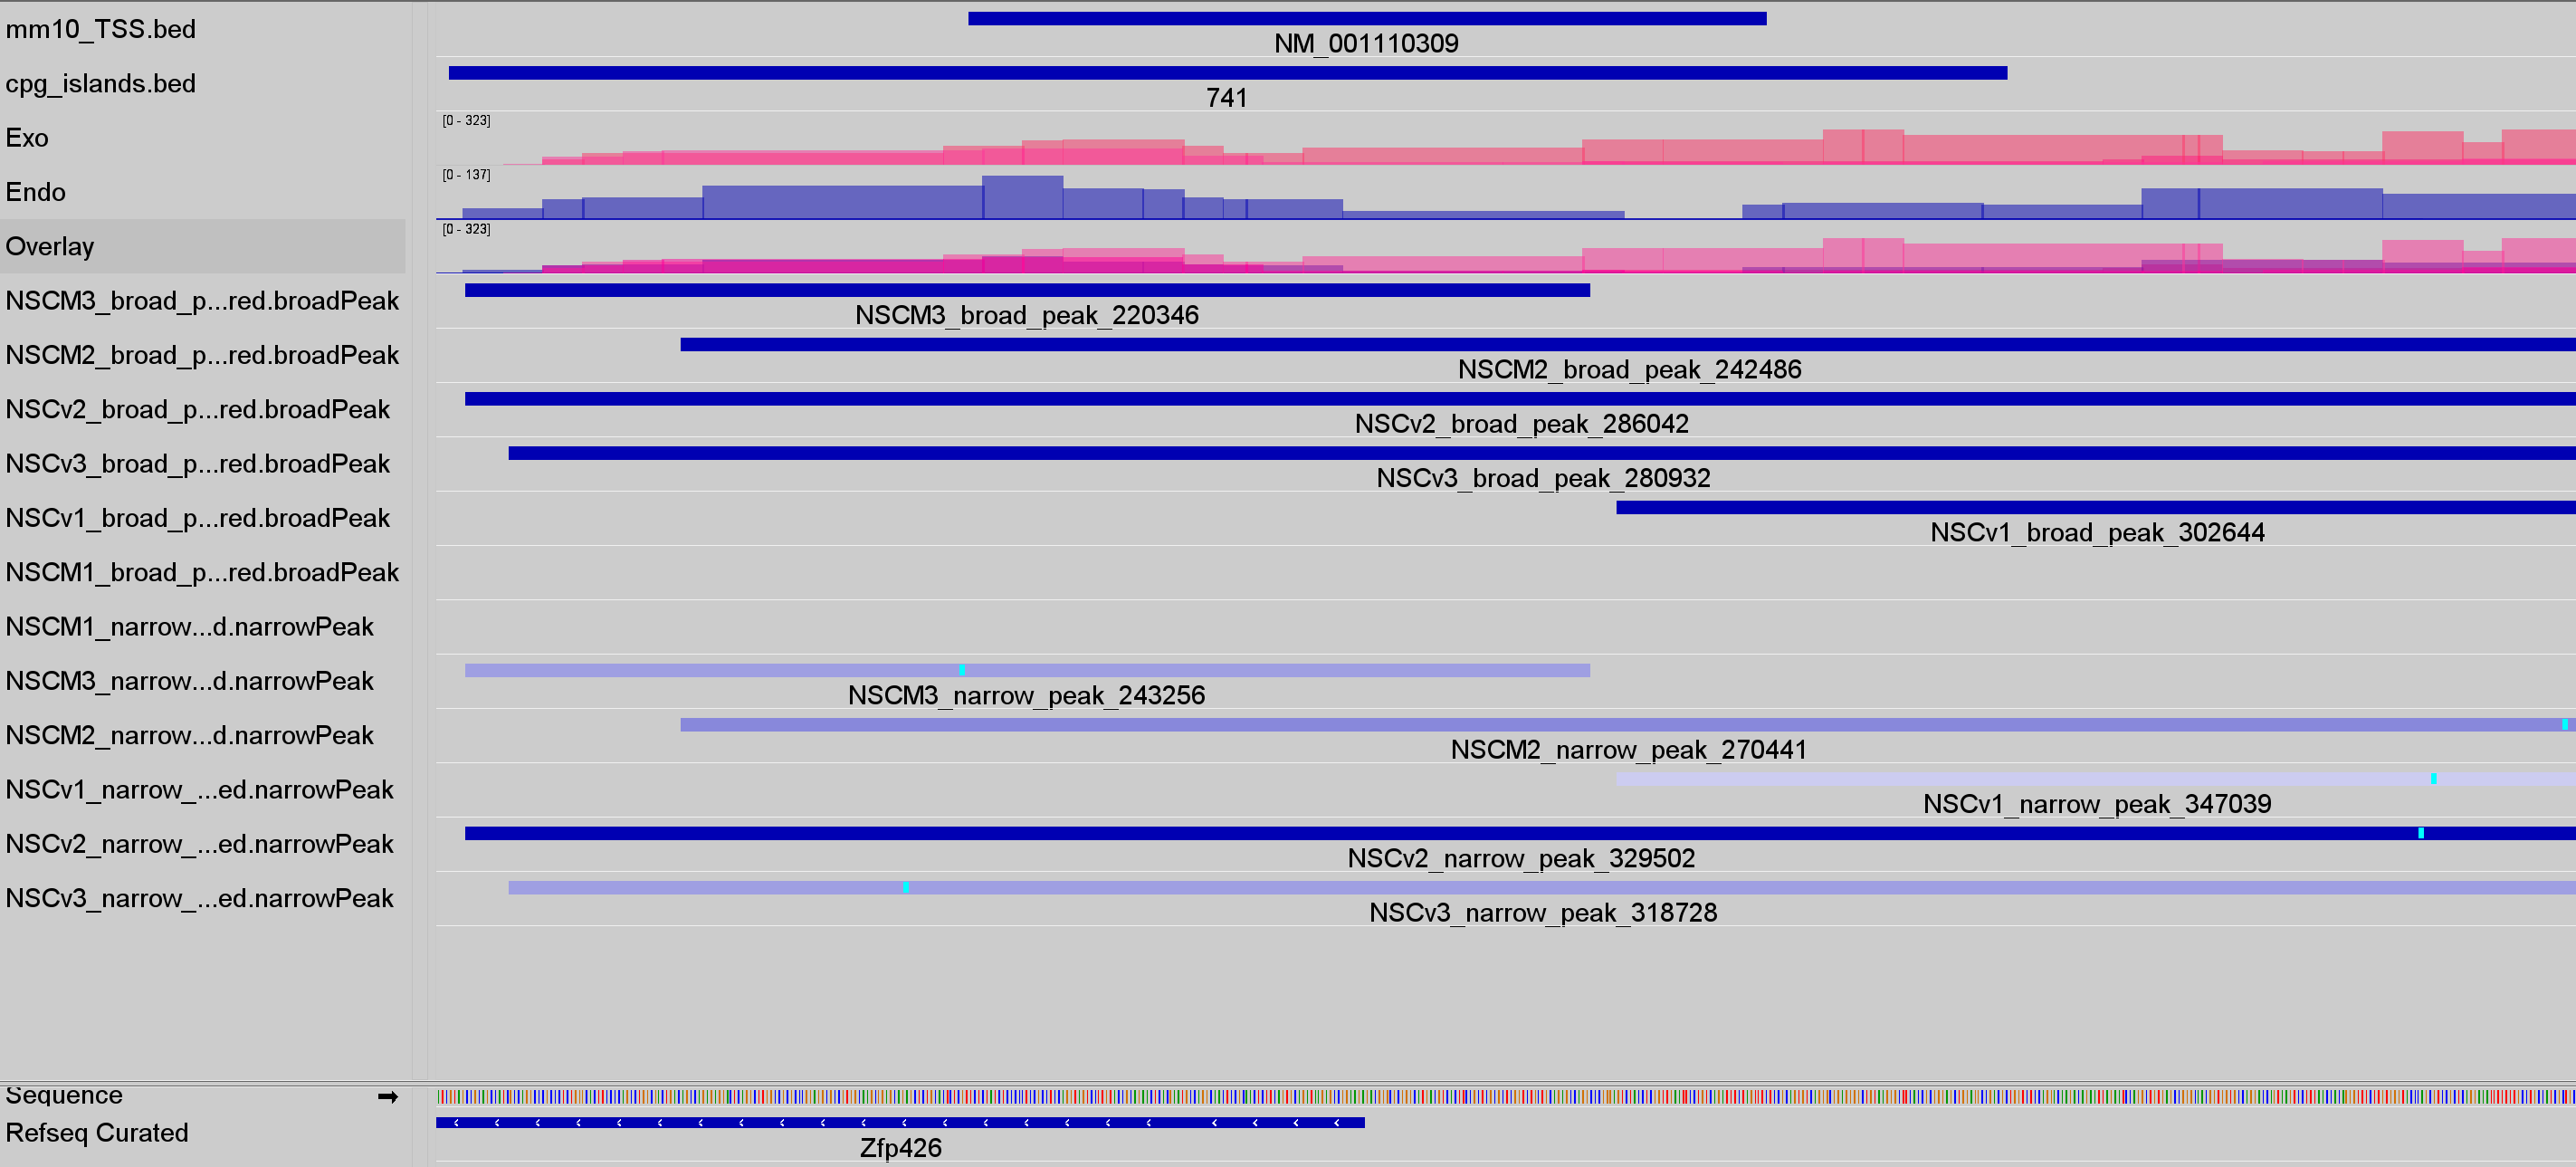

## Regions length distribution

### Region length - defined by the outermost peaks coordinates

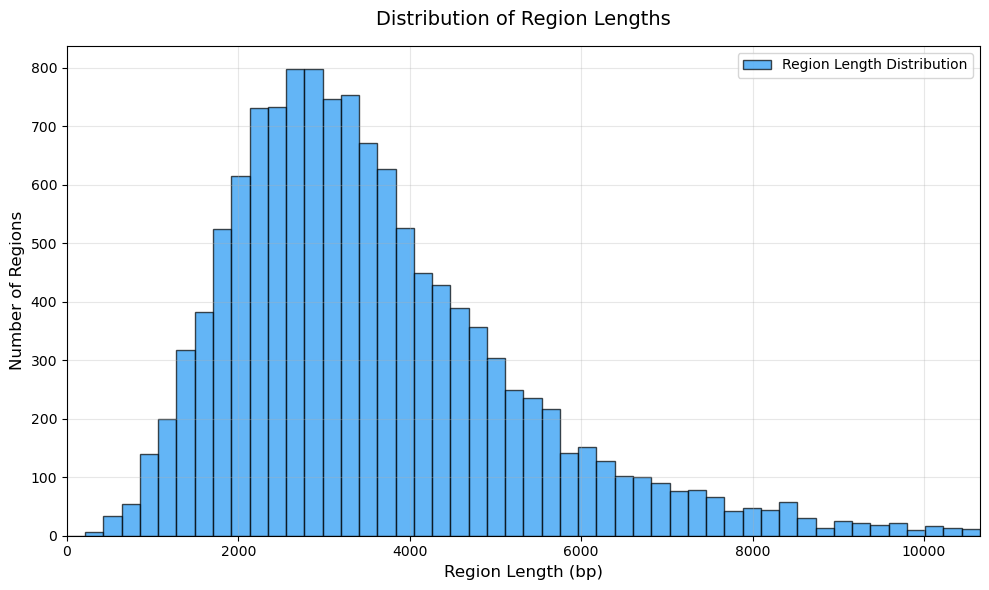

In [57]:
plt.figure(figsize=(10, 6))

# Calculate reasonable range based on data distribution
q1, q3 = both_df['region_length'].quantile([0.25, 0.75])
factor = 3
iqr = q3 - q1
range_min = max(0, q1 - factor * iqr)  # Don't go below 0 for region_length
range_max = q3 + factor * iqr

n, bins, patches = plt.hist(both_df['region_length'], bins=50, edgecolor='black', alpha=0.7,
                          color='#2196F3', density=False, range=(range_min, range_max),
                          label='Region Length Distribution')

plt.grid(True, alpha=0.3)

plt.xlabel('Region Length (bp)', fontsize=12)
plt.ylabel('Number of Regions', fontsize=12)
plt.title('Distribution of Region Lengths',
          fontsize=14, pad=15)

plt.xlim(range_min, range_max)

plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [67]:
both_df_sorted_by_region_length = both_df.sort_values(by='region_length', ascending=False)
both_df_sorted_by_region_length.head()

,chr,start,end,exo_signal,endo_signal,enrichment,pvalue,binding_type,binding_type_by_peaks,significant,exo_replicates_with_signal,endo_replicates_with_signal,exo_replicate_signals,endo_replicate_signals,region_length,cpg_length,cpg_score,cpg_name,exo_replicates_with_peaks,endo_replicates_with_peaks,exo_peak_scores_by_rep,endo_peak_scores_by_rep,region_start,region_end
10522,chr7,45717703,45718318,31.806518,36.448500,0.872643,1.0,both,both,False,3,3,"33.03791549623241,34.05267709520635,28.32896270983769","46.28682986409696,31.1067631678273,31.95190802204576",21582,615,CpG:,933,3,2,6.44844;4.51086;8.79106,4.89628;11.8479,45700675,45722257
10521,chr7,45714976,45715370,33.748239,41.276677,0.817610,0.4,both,both,False,3,3,"35.39147714133252,35.71502853770806,30.138211381089384","50.575669412973255,38.321259069942876,34.93310139458494",19164,394,CpG:,933,3,3,13.0324;9.20095;9.97968,16.9373;6.68945;11.8479,45700675,45719839
10517,chr7,45704790,45705154,33.748239,41.276677,0.817610,0.4,both,both,False,3,3,"35.39147714133252,35.71502853770806,30.138211381089384","50.575669412973255,38.321259069942876,34.93310139458494",19164,364,CpG:,933,3,3,11.8131;10.0331;11.1781,28.2728;12.7485;11.8479,45700675,45719839
10518,chr7,45705454,45705704,33.748239,41.276677,0.817610,0.4,both,both,False,3,3,"35.39147714133252,35.71502853770806,30.138211381089384","50.575669412973255,38.321259069942876,34.93310139458494",19164,250,CpG:,933,3,3,11.8131;10.0331;11.1781,28.2728;12.7485;11.8479,45700675,45719839
10520,chr7,45713359,45713615,33.748239,41.276677,0.817610,0.4,both,endo_only,False,3,3,"35.39147714133252,35.71502853770806,30.138211381089384","50.575669412973255,38.321259069942876,34.93310139458494",19164,256,CpG:,933,0,3,NaN,6.8612;6.68945;11.8479,45700675,45719839


In [68]:
# Print first 10 and last 10 region_length sorted by region_length value
print("\nFirst 10 region_length:")
for _, row in both_df_sorted_by_region_length[:10].iterrows():
    print(f"{row['chr']}:{row['start']:,}-{row['end']:,}".ljust(50) + 
          f"enrichment: {row['enrichment']:<10.2f}" +
          f"region_length: {row['region_length']:<10}" + 
          f"cpg_length: {row['cpg_length']}")


First 10 region_length:
chr7:45,717,703-45,718,318                        enrichment: 0.87      region_length: 21582     cpg_length: 615
chr7:45,714,976-45,715,370                        enrichment: 0.82      region_length: 19164     cpg_length: 394
chr7:45,704,790-45,705,154                        enrichment: 0.82      region_length: 19164     cpg_length: 364
chr7:45,705,454-45,705,704                        enrichment: 0.82      region_length: 19164     cpg_length: 250
chr7:45,713,359-45,713,615                        enrichment: 0.82      region_length: 19164     cpg_length: 256
chr7:45,706,651-45,707,060                        enrichment: 0.82      region_length: 19164     cpg_length: 409
chr4:154,960,617-154,961,702                      enrichment: 0.90      region_length: 17935     cpg_length: 1085
chr5:142,905,576-142,906,846                      enrichment: 0.74      region_length: 16435     cpg_length: 1270
chr18:34,860,474-34,861,222                       enrichment: 0.50   

chr7:45,717,703-45,718,318 

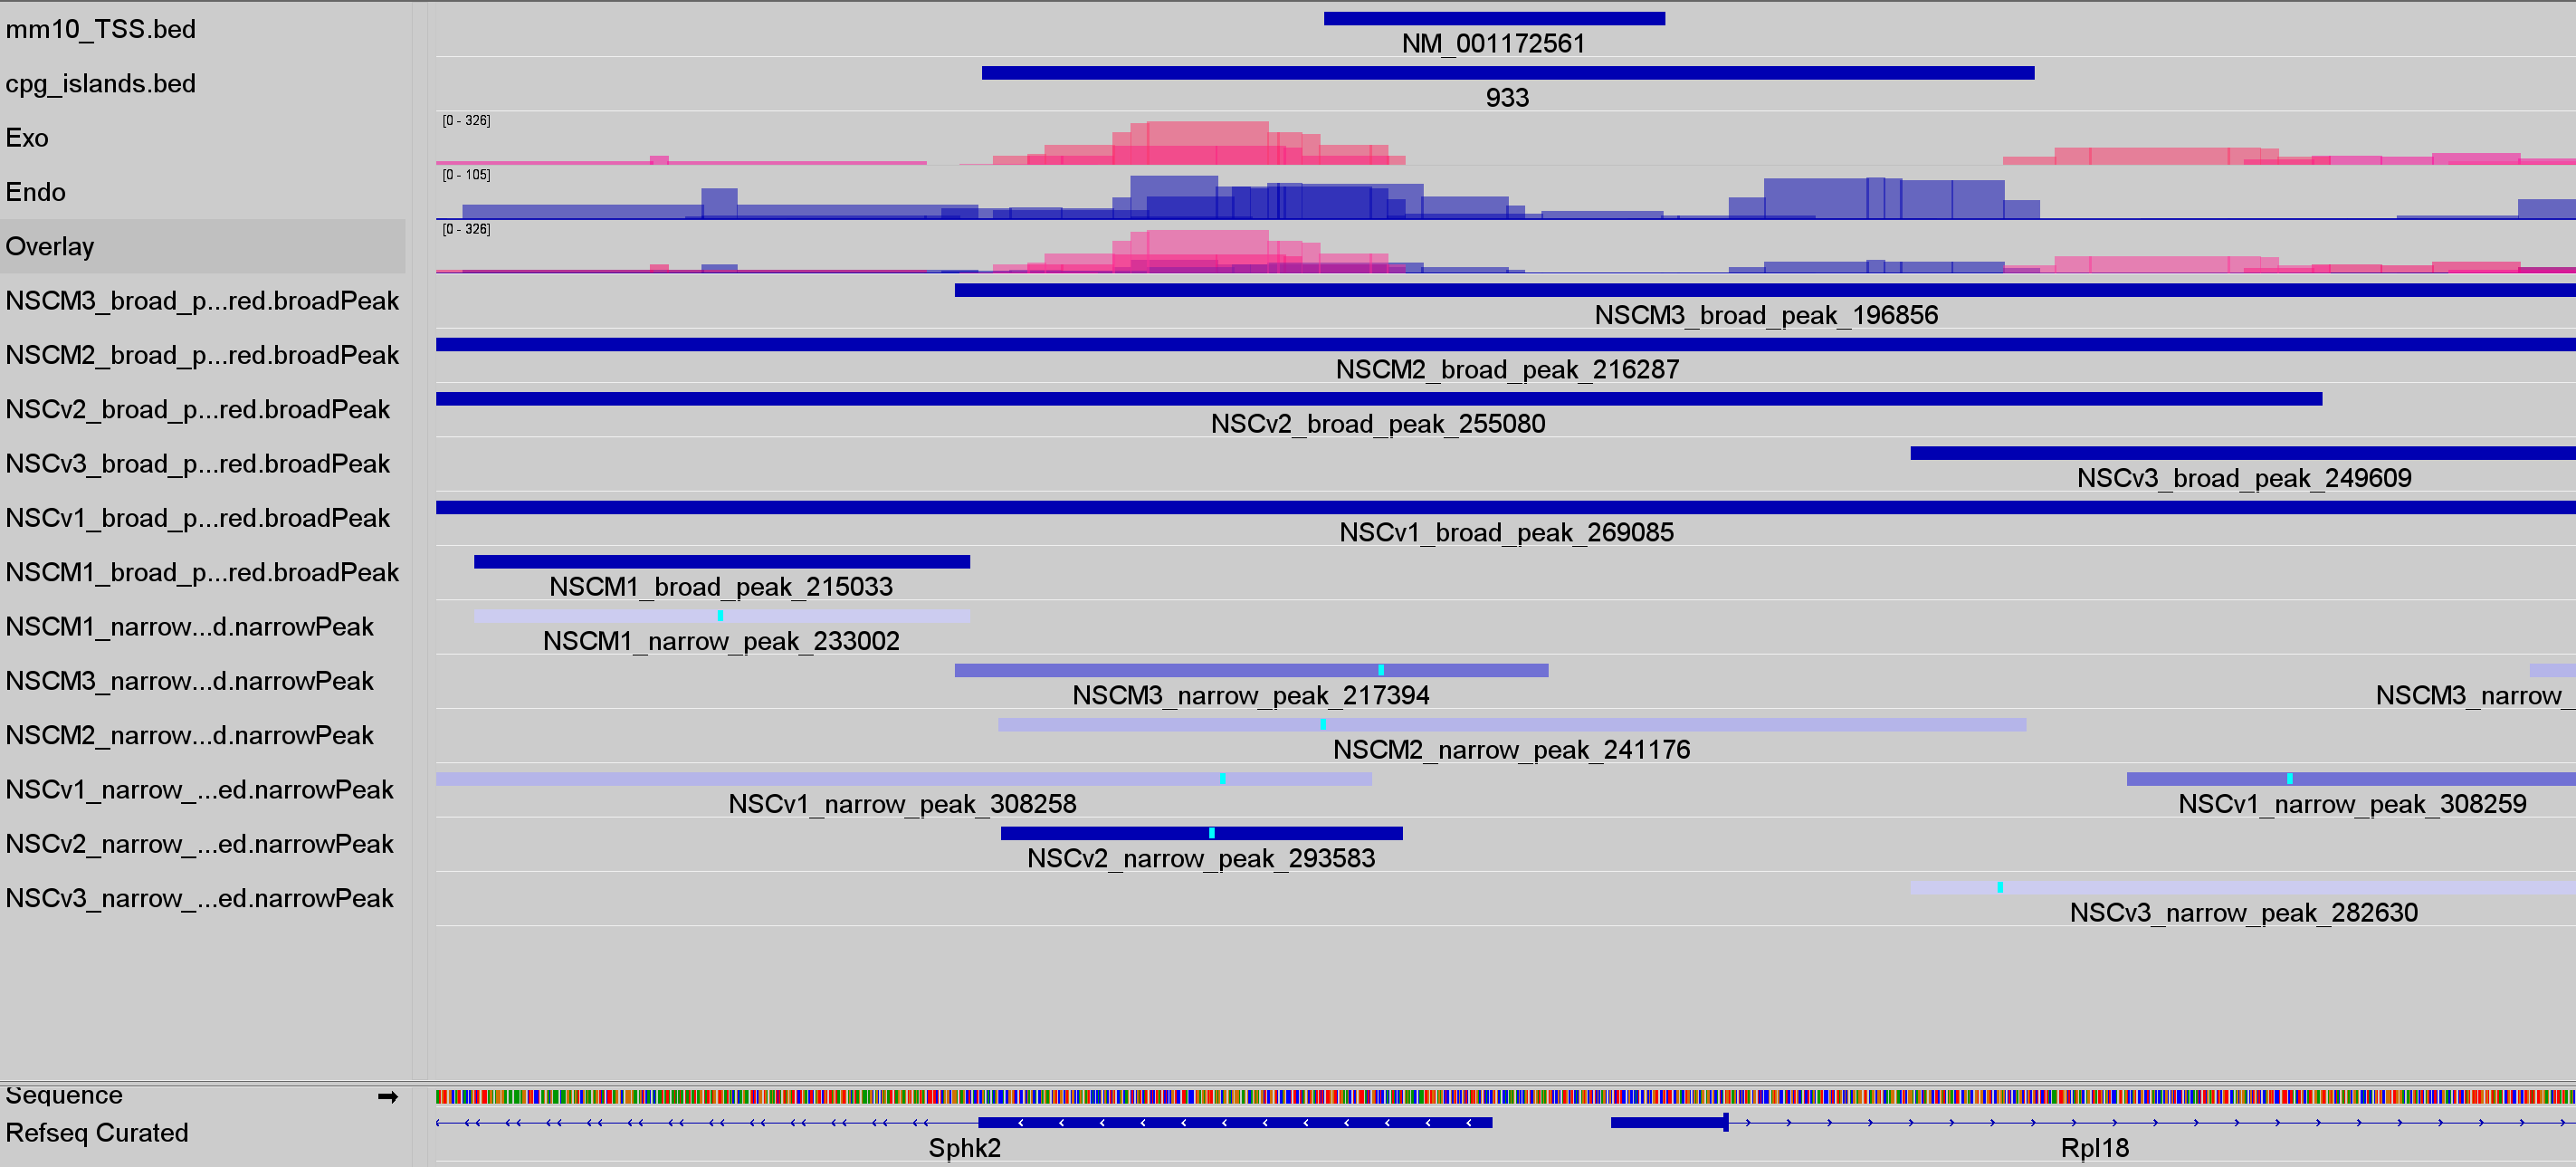

### CpG length - defined by the CpG coordinates

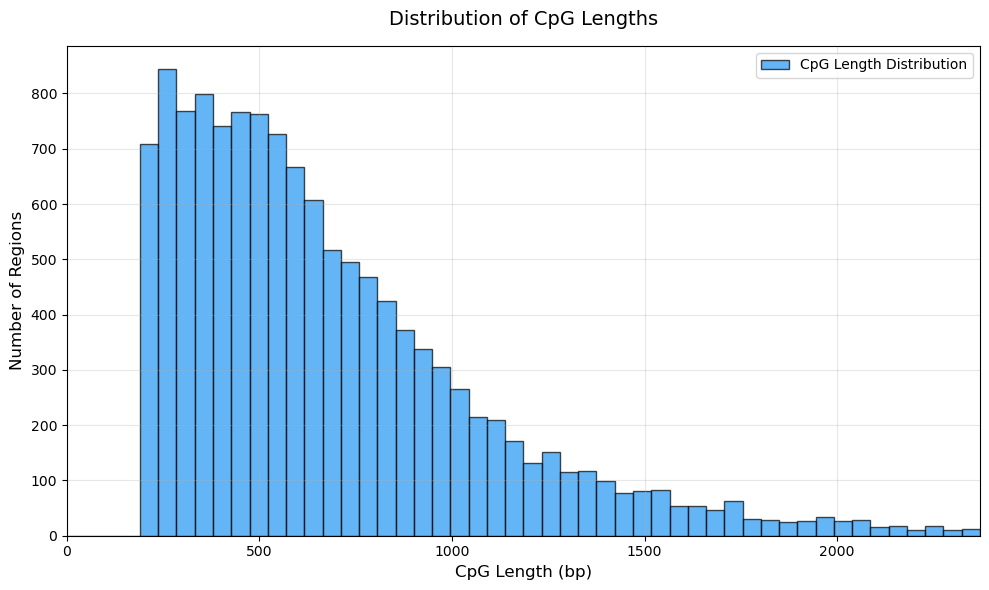

In [58]:
plt.figure(figsize=(10, 6))

# Calculate reasonable range based on data distribution
q1, q3 = both_df['cpg_length'].quantile([0.25, 0.75])
factor = 3
iqr = q3 - q1
range_min = max(0, q1 - factor * iqr)  # Don't go below 0 for cpg_length
range_max = q3 + factor * iqr

n, bins, patches = plt.hist(both_df['cpg_length'], bins=50, edgecolor='black', alpha=0.7,
                          color='#2196F3', density=False, range=(range_min, range_max),
                          label='CpG Length Distribution')

plt.grid(True, alpha=0.3)

plt.xlabel('CpG Length (bp)', fontsize=12)
plt.ylabel('Number of Regions', fontsize=12)
plt.title('Distribution of CpG Lengths',
          fontsize=14, pad=15)

plt.xlim(range_min, range_max)

plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [62]:
both_df_sorted_by_cpg_length = both_df.sort_values(by='cpg_length', ascending=False)
both_df_sorted_by_cpg_length.head()

,chr,start,end,exo_signal,endo_signal,enrichment,pvalue,binding_type,binding_type_by_peaks,significant,exo_replicates_with_signal,endo_replicates_with_signal,exo_replicate_signals,endo_replicate_signals,region_length,cpg_length,cpg_score,cpg_name,exo_replicates_with_peaks,endo_replicates_with_peaks,exo_peak_scores_by_rep,endo_peak_scores_by_rep,region_start,region_end
11531,chr8,92355697,92360826,42.941446,26.319932,1.631518,0.200000,both,both,False,3,3,"58.38007196083061,28.31231615392961,42.13195109525202","32.89087279934749,27.479288501670798,18.589635815970436",10272,5129,CpG:,1289,3,3,"13.6064,5.30278;14.9207,9.0069;13.5209,3.745","7.97736,3.88097;13.636;13.307",92353428,92363700
8808,chr5,33430439,33435552,3.453756,1.695373,2.037167,0.333333,both,both,False,2,2,"7.120998398522761,3.240270929723442,0.0","2.5871079104657655,2.499009762185231,0.0",4782,5113,CpG:,840,2,2,"4.49647,2.16476;5.54937",3.53897;2.89962,33430734,33435516
12549,chrX,12086982,12092060,14.087832,12.661401,1.112660,1.000000,both,both,False,3,3,"9.935600149496143,11.530938575347747,20.796957398140876","10.968383283548377,11.194259156518477,15.821561578524468",7574,5078,CpG:,677,3,3,"4.64723,6.7883;4.53249,3.1331;6.22426,4.01535","5.12662,5.46241;3.1565,4.16453;3.84065,5.41912",12086376,12093950
12548,chrX,12076861,12081915,13.526196,10.369226,1.304456,1.000000,both,both,False,3,3,"23.403473759556675,4.78802524062218,12.387088269454903","15.056476755676643,5.158452246458153,10.892749999857873",6549,5054,CpG:,677,3,3,"4.76224,4.41723;17.0176,6.45927;5.38684","4.8797,5.17184;4.92708;6.45067,3.87285",12076351,12082900
5076,chr17,34118396,34122981,22.579512,21.901637,1.030951,1.000000,both,both,False,3,3,"25.799158418499218,30.229833089623042,11.709544068702746","27.59327559564927,20.548877809861075,17.562756901005457",8439,4585,CpG:,845,3,3,"2.71363,5.77105;8.0073,4.44732;6.95785","7.37711;8.4697,7.40291;5.41871",34117342,34125781


In [64]:
# Print first 10 and last 10 cpg_length sorted by cpg_length value
print("\nFirst 10 cpg_length:")
for _, row in both_df_sorted_by_cpg_length[:10].iterrows():
    print(f"{row['chr']}:{row['start']:,}-{row['end']:,}".ljust(50) + 
          f"enrichment: {row['enrichment']:<10.2f}" +
          f"region_length: {row['region_length']:<10}" + 
          f"cpg_length: {row['cpg_length']}")


First 10 cpg_length:
chr8:92,355,697-92,360,826                        enrichment: 1.63      region_length: 10272     cpg_length: 5129
chr5:33,430,439-33,435,552                        enrichment: 2.04      region_length: 4782      cpg_length: 5113
chrX:12,086,982-12,092,060                        enrichment: 1.11      region_length: 7574      cpg_length: 5078
chrX:12,076,861-12,081,915                        enrichment: 1.30      region_length: 6549      cpg_length: 5054
chr17:34,118,396-34,122,981                       enrichment: 1.03      region_length: 8439      cpg_length: 4585
chr8:87,958,428-87,962,795                        enrichment: 1.51      region_length: 7367      cpg_length: 4367
chr3:93,443,613-93,447,951                        enrichment: 1.10      region_length: 5562      cpg_length: 4338
chr11:120,233,787-120,238,101                     enrichment: 1.17      region_length: 7497      cpg_length: 4314
chr7:82,865,931-82,870,227                        enrichment: 1.29

chr8:92,355,697-92,360,826

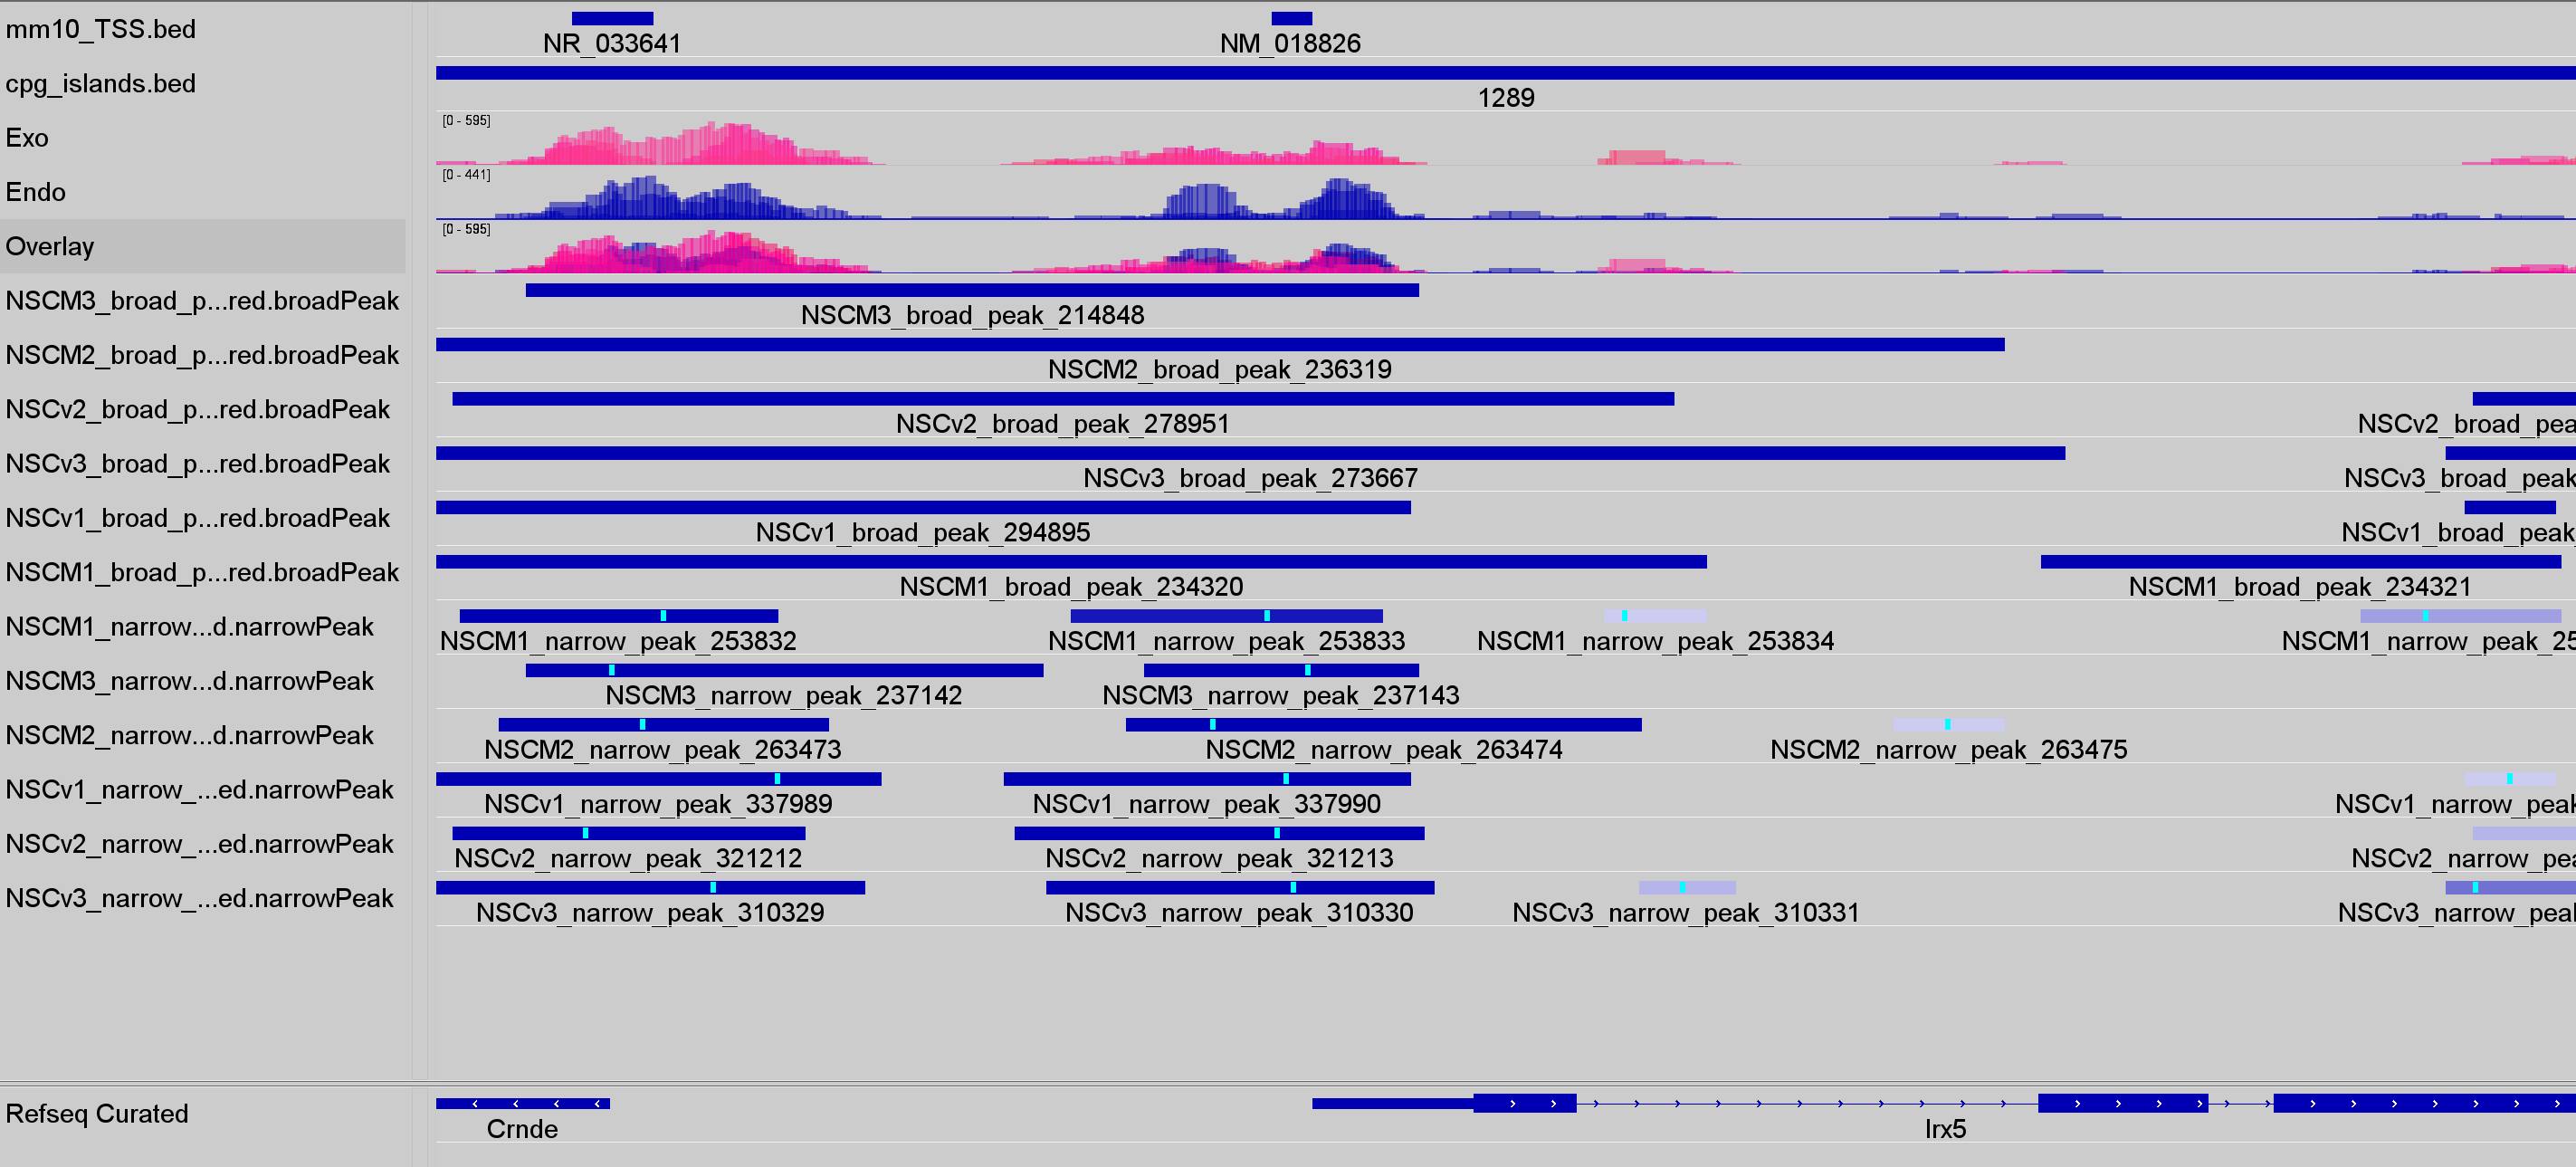

# Exo only

In [45]:
exo_only_df.head()

,chr,start,end,exo_signal,endo_signal,enrichment,pvalue,binding_type,binding_type_by_peaks,significant,exo_replicates_with_signal,endo_replicates_with_signal,exo_replicate_signals,endo_replicate_signals,region_length,cpg_length,cpg_score,cpg_name,exo_replicates_with_peaks,endo_replicates_with_peaks,exo_peak_scores_by_rep,endo_peak_scores_by_rep,region_start,region_end
6085,chr19,44734343,44735056,15.453329,0.0,inf,1.0,exo_only,exo_only,False,2,0,"0.0,8.257254110088892,38.10273315233162","0.0,0.0,0.0",1087,713,CpG:,926,2,0,6.33438;4.07766,NaN,44734499,44735586
3330,chr13,96748199,96748403,33.173716,0.0,inf,1.0,exo_only,exo_only,False,2,0,"55.65521597415767,43.86593215027998,0.0","0.0,0.0,0.0",267,204,CpG:,1323,2,0,5.32714;4.40742,NaN,96748259,96748526
12797,chrX,159414230,159415517,15.982540,0.0,inf,1.0,exo_only,exo_only,False,3,0,"6.530822352008576,12.00851120687891,29.40828514321164","0.0,0.0,0.0",859,1287,CpG:,1801,2,0,3.18458;3.75447,NaN,159413536,159414395
12819,chrX,168122986,168123301,17.661884,0.0,inf,1.0,exo_only,exo_only,False,2,0,"29.36382449578945,23.621828120347168,0.0","0.0,0.0,0.0",974,315,CpG:,1867,2,0,3.28488;4.05905,NaN,168122898,168123872
5293,chr17,68003884,68004335,52.088128,0.0,inf,1.0,exo_only,exo_only,False,3,0,"58.904634082973196,22.413534491579124,74.94621410184693","0.0,0.0,0.0",309,451,CpG:,1103,2,0,7.68799;2.60943,NaN,68004184,68004493


In [53]:
# Generate summary statistics for numeric columns, ignoring inf values
numeric_cols = ['exo_signal', 'endo_signal', 'enrichment', 'region_length', 'cpg_length', 'pvalue']
# Replace inf values with NaN before calculating statistics
stats_df = exo_only_df[numeric_cols].replace([np.inf, -np.inf], np.nan).describe()
stats_df

,exo_signal,endo_signal,enrichment,region_length,cpg_length,pvalue
count,126.000000,126.000000,96.000000,126.000000,126.000000,126.000000
mean,18.933008,2.528809,34.711849,1268.126984,616.563492,0.783069
std,8.803885,3.501246,72.198017,690.423116,469.746732,0.225359
min,2.610753,0.000000,0.370688,267.000000,201.000000,0.500000
25%,13.082354,0.058089,3.494993,797.500000,328.250000,0.500000
50%,16.988029,1.121255,8.893094,1156.500000,435.000000,0.833333
75%,22.735562,3.596718,26.718899,1590.500000,697.500000,1.000000
max,52.088128,17.419247,497.676069,3910.000000,2455.000000,1.000000


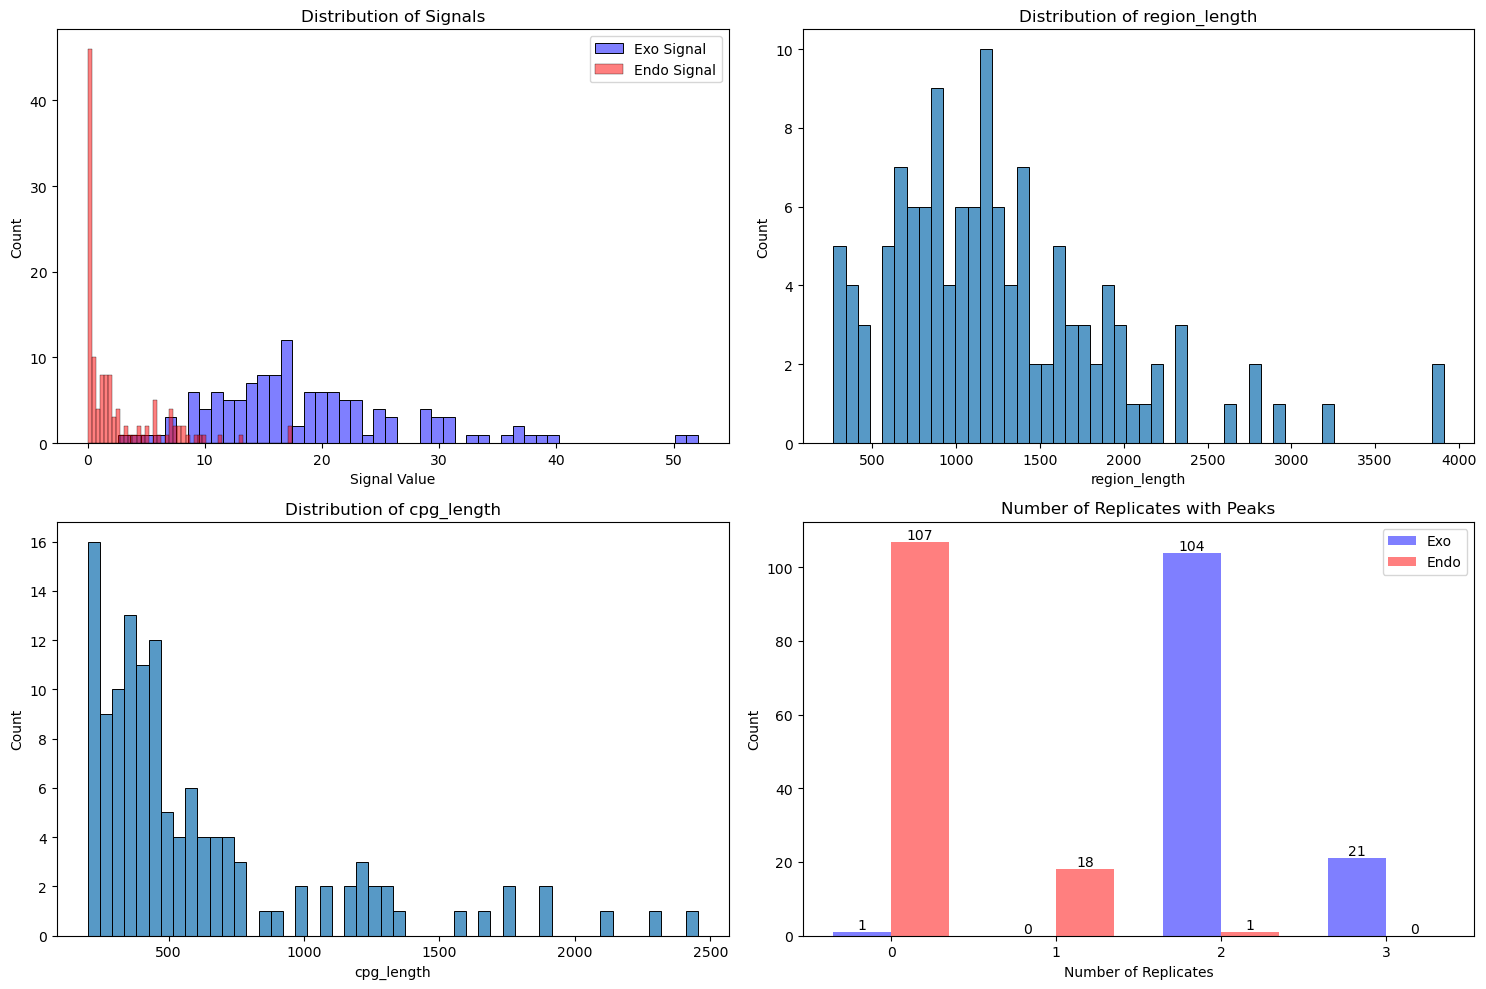

In [63]:
# Distribution plots
plt.figure(figsize=(15, 10))

# Plot overlapped signal distributions
plt.subplot(2, 2, 1)
sns.histplot(data=exo_only_df, x='exo_signal', bins=50, alpha=0.5, label='Exo Signal', color='blue')
sns.histplot(data=exo_only_df, x='endo_signal', bins=50, alpha=0.5, label='Endo Signal', color='red')
plt.title('Distribution of Signals')
plt.xlabel('Signal Value')
plt.ylabel('Count')
plt.legend()

# Plot region length distribution
plt.subplot(2, 2, 2)
sns.histplot(data=exo_only_df, x='region_length', bins=50)
plt.title('Distribution of region_length')
plt.xlabel('region_length')
plt.ylabel('Count')

# Plot CpG length distribution
plt.subplot(2, 2, 3)
sns.histplot(data=exo_only_df, x='cpg_length', bins=50)
plt.title('Distribution of cpg_length')
plt.xlabel('cpg_length')
plt.ylabel('Count')

# Count peaks per region
plt.subplot(2, 2, 4)
exo_peak_counts = exo_only_df['exo_replicates_with_peaks'].value_counts()
endo_peak_counts = exo_only_df['endo_replicates_with_peaks'].value_counts()

x = np.arange(max(max(exo_peak_counts.index), max(endo_peak_counts.index)) + 1)
width = 0.35

# Create bars and store them to add labels
exo_bars = plt.bar(x - width/2, [exo_peak_counts.get(i, 0) for i in x], width, label='Exo', color='blue', alpha=0.5)
endo_bars = plt.bar(x + width/2, [endo_peak_counts.get(i, 0) for i in x], width, label='Endo', color='red', alpha=0.5)

# Add count labels on top of each bar
for bars in [exo_bars, endo_bars]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')

plt.title('Number of Replicates with Peaks')
plt.xlabel('Number of Replicates')
plt.ylabel('Count')
plt.legend()

plt.xticks(x, x.astype(int))
plt.tight_layout()
plt.show()

# Endo only

In [44]:
endo_only_df.head()

,chr,start,end,exo_signal,endo_signal,enrichment,pvalue,binding_type,binding_type_by_peaks,significant,exo_replicates_with_signal,endo_replicates_with_signal,exo_replicate_signals,endo_replicate_signals,region_length,cpg_length,cpg_score,cpg_name,exo_replicates_with_peaks,endo_replicates_with_peaks,exo_peak_scores_by_rep,endo_peak_scores_by_rep,region_start,region_end
7192,chr2,178119043,178119439,22.932079,8.782935,2.610981,0.666667,endo_only,exo_only,False,1,2,"68.79623773748224,0.0,0.0","0.0,6.798229148171165,19.55057632489638",550,396,CpG:,1943,2,0,4.31701;11.8396,NaN,178118795,178119345
3372,chr13,104863566,104863806,15.741889,8.054011,1.954540,0.500000,endo_only,endo_only,False,1,3,"47.225667965933624,0.0,0.0","18.354512960839436,0.5044132768421656,5.303108174345261",1303,240,CpG:,1385,1,2,9.01433,2.34948;5.25197,104863330,104864633
6200,chr2,4603471,4604164,8.555185,4.389919,1.948825,0.666667,endo_only,exo_only,False,1,2,"25.66555402272497,0.0,0.0","7.6619685865878635,0.0,5.507787040225501",1117,693,CpG:,620,2,1,9.02221;7.07031,5.46819,4603177,4604294
4791,chr16,97763144,97763933,9.271275,14.137734,0.655782,0.500000,endo_only,endo_only,False,1,3,"0.0,27.813825069774282,0.0","14.46889169833877,22.273494944789192,5.670814655585723",2200,789,CpG:,1330,1,2,7.31516,4.98337;6.06847,97762019,97764219
3316,chr13,94876988,94877530,5.331712,12.266721,0.434648,1.000000,endo_only,endo_only,False,1,3,"0.0,0.0,15.995134565990451","22.478218573146503,0.4541344401111813,13.867809318611352",1994,542,CpG:,1308,1,2,6.66024,10.0576;4.87034,94876449,94878443
